In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D 
from ipywidgets import interact
import seaborn as sns
import squarify
import warnings
from datetime import datetime
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import KNNImputer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score

In [2]:
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [4]:
url = '/kaggle/input/customer-personality-analysis/marketing_campaign.csv'
df = pd.read_csv(url, sep='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [5]:
print('Rows:',df.shape[0])
print('Columns:',df.shape[1])

Rows: 2240
Columns: 29


**Info about the dataset:**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [7]:
df.select_dtypes('object').nunique()

Education           5
Marital_Status      8
Dt_Customer       663
dtype: int64

In [8]:
df.describe(percentiles=[.05,.5,.25,.75,.95,.99])

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
5%,576.850000,1950.000000,18985.500000,0.000000,0.000000,4.000000,3.000000,0.000000,4.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
95%,10675.050000,1988.000000,84130.000000,1.000000,1.000000,94.000000,1000.000000,123.000000,687.100000,168.050000,126.000000,165.050000,6.000000,9.000000,9.000000,12.000000,8.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3.0,11.0,1.000000
99%,11074.610000,1992.000000,94458.800000,2.000000,2.000000,98.000000,1285.000000,172.000000,915.000000,226.220000,177.220000,227.000000,10.000000,11.000000,10.610000,13.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.0,11.0,1.000000


In [9]:
print("Duplicated records:",df.duplicated().sum())

Duplicated records: 0


In [10]:
df.Education.value_counts(dropna=False, normalize=True)

Education
Graduation    0.503125
PhD           0.216964
Master        0.165179
2n Cycle      0.090625
Basic         0.024107
Name: proportion, dtype: float64

In [11]:
df.Marital_Status.value_counts(dropna=False, normalize=True)

Marital_Status
Married     0.385714
Together    0.258929
Single      0.214286
Divorced    0.103571
Widow       0.034375
Alone       0.001339
Absurd      0.000893
YOLO        0.000893
Name: proportion, dtype: float64

In [12]:
last_year = pd.to_datetime(df.Dt_Customer, format='%d-%m-%Y').dt.year.max()
print("We'll calculate the age of the customers based on this year: ",last_year)

We'll calculate the age of the customers based on this year:  2014


In [13]:
# Let's make a copy of the dataset
df_copy = df.copy()

In [14]:
def initial_cleaning(df):
    """Do the initial changes describe it above"""
    # Drop columns 
    df.drop(['ID','Z_CostContact','Z_Revenue'], axis=1, inplace=True)
    # Transform the format of dt_customer
    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'],format="%d-%m-%Y")
    # Substitutions in Marital Status column
    df['Marital_Status'] = df.loc[:,'Marital_Status'].str.replace('Alone','Single')
    df['Marital_Status'] = df.loc[:,'Marital_Status'].apply(lambda x: "Single" if x == 'YOLO' or x == 'Absurd' else x)
    # Rename columns for more practicity
    df.columns = df.columns.str.lower()
    # Create new column
    df['younghome'] = df.kidhome + df.teenhome
    return df

df_copy = initial_cleaning(df_copy)

In [15]:
def feat_engineering(df):
    not_graduated = ['Basic','2n cycle']
    couple = ['Married','Together']
    df['age'] = max(df['dt_customer'].dt.year) - df['year_birth']
    df['graduated'] = df['education'].apply(lambda x: 'Not Graduated' if x in not_graduated else 'Graduated')
    df['partner'] = df['marital_status'].apply(lambda x: 'Partner' if x in couple else 'No Partner')
    return df

df_copy = feat_engineering(df_copy);

**Set theme for further visualizations**

In [16]:
sns.set_theme(context= 'notebook')
sns.set_style('dark')
sns.set(rc={'axes.grid':False})
sns.set_palette('mako')

**Some plot functions:**

In [17]:
def num_plot(df, col):
  """Graph an histogram with a boxplot above
	for one numerical column"""
  fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,4),gridspec_kw={"height_ratios": (.2, .8)})
  sns.boxplot(x=col, data=df, ax=ax[0], color='#7171cf', linewidth=1.5)
  ax[0].set_xlabel(None)
  ax[0].set(yticks=[])
  sns.histplot(x=col, data=df, ax=ax[1], alpha=.6, color='#7171cf')
  ax[1].set_xlabel(col.replace('_',' ').title(), fontsize=22, loc= 'left')
  plt.axvline(df[col].mean(), color='#39568CFF', linewidth=2.2, label='mean=' + str(np.round(df[col].mean(),1)))
  plt.axvline(df[col].median(), color='#1F968BFF', linewidth=2.2, label='median='+ str(np.round(df[col].median(),1)))
  plt.axvline(df[col].mode()[0], color='#440154FF', linewidth=2.2, label='mode='+ str(df[col].mode()[0]))
  plt.legend(bbox_to_anchor=(1, 1.03), ncol=1, fontsize=10, fancybox=True, shadow=True, frameon=True)
  plt.tight_layout()
  return ax 

def countplot_catcols(df,column,width,height):
	"""Count frequency for each group"""
	fig, ax  = plt.subplots(figsize=(width,height))
	ax=sns.countplot(y=column, data=df, 
                  palette='viridis',
                  orient='h',
				  order = df[column].value_counts().index)
	ax.set_xticklabels(ax.get_xticklabels())
	ax.bar_label(ax.containers[0])
	ax.set_title(f'Frequency of {column} categories', loc='left', size=18)
	plt.tight_layout()
	return ax

def barplot_category(df,x,y,title):
  """Plot a barplot"""
  fig, ax  = plt.subplots(figsize=(8,2))
  ax  = sns.barplot(data=df, x=x, y=y,
              orient='h', palette='mako',
              seed=2)
  plt.title(title, loc='left', size=16)
  return ax

## 4.1 What's the demographic profile of our customers?

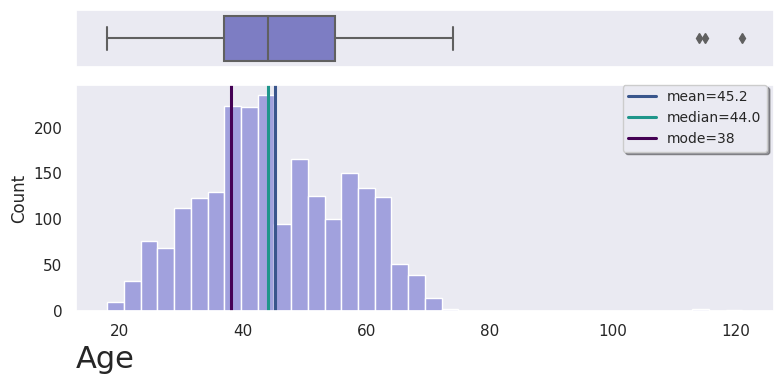

In [18]:
num_plot(df_copy, 'age')
plt.show()

**Discretize `year_birth` column**

In [19]:
age_clusters = pd.cut(df_copy.age, [-np.inf,30,60,np.inf], 
                      labels=['young','adult','elderly'])
age_clusters.value_counts(normalize=True).sort_index()

age
young      0.115625
adult      0.764286
elderly    0.120089
Name: proportion, dtype: float64

In [20]:
df_copy['age_category'] = age_clusters

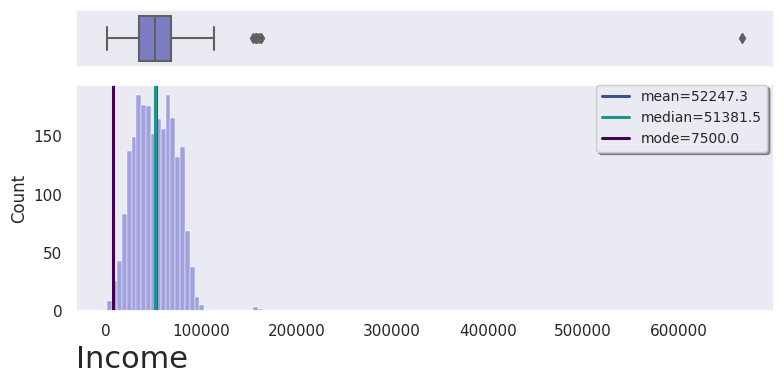

In [21]:
num_plot(df_copy, 'income')
plt.show()

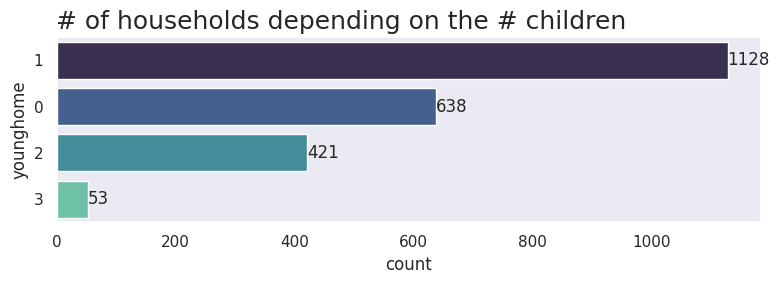

In [22]:
fig, ax  = plt.subplots(figsize=(8,3))
ax=sns.countplot(y='younghome', data=df_copy, 
                  palette='mako',
                  orient='h',
				  order = df_copy['younghome'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels())
ax.bar_label(ax.containers[0])
ax.set_title('# of households depending on the # children', loc='left', size=18)
plt.tight_layout()
plt.show()

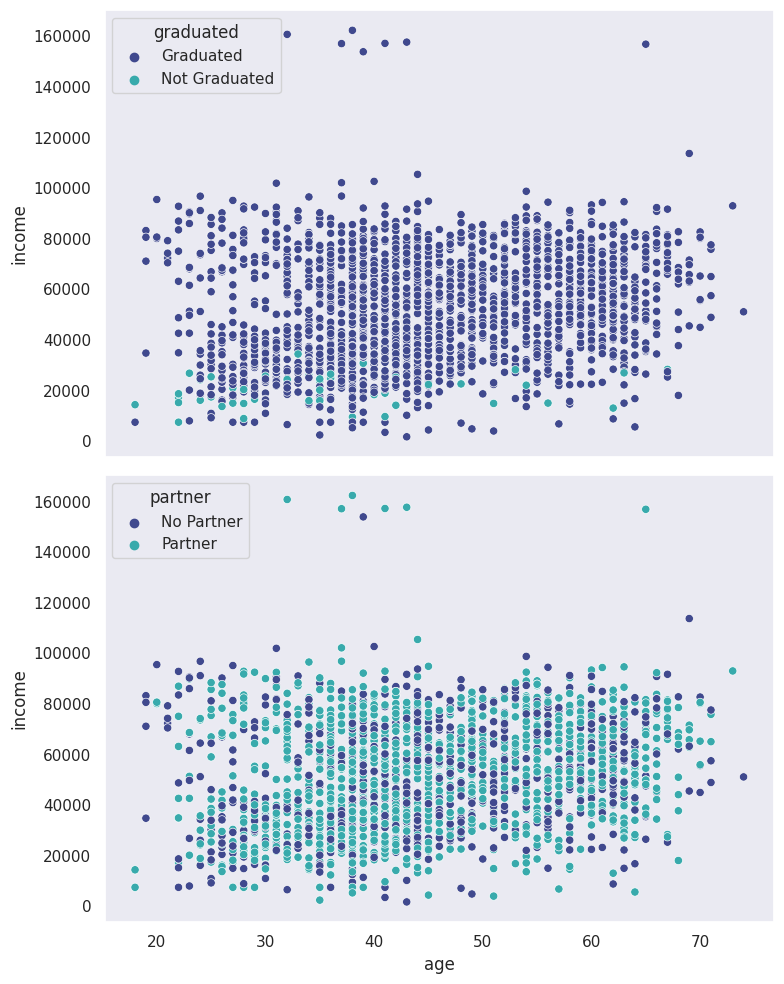

In [23]:
df_without_outliers = df_copy.loc[(df_copy.age < 100) & (df_copy.income < 200_000)]

fig, ax = plt.subplots(2,1, figsize=(8,10), sharex=True)
sns.scatterplot(data=df_without_outliers, 
                x='age', 
                y='income',
                hue='graduated', 
                palette='mako',
               ax=ax[0])

sns.scatterplot(data=df_without_outliers, 
                x='age', 
                y='income',
                hue='partner', 
                palette='mako',
               ax=ax[1])
plt.tight_layout()
plt.show()

* We can't appreciate any significant pattern due to the overlap.

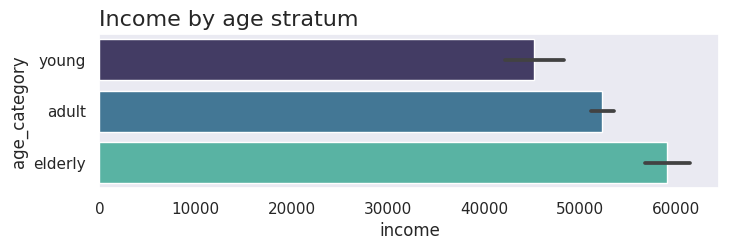

In [24]:
barplot_category(df_copy,'income','age_category','Income by age stratum')
plt.show()

## 4.2 Which patterns can we find in their spending behavior?

**What kind of relation is between customers and what they purchase?**

In [25]:
# Select only a few features of interest at this moment
products_subset = df_copy.loc[:, :'mntgoldprods'].drop(['kidhome','teenhome','year_birth'], axis=1) 
demographic_subset = df_copy[['age','age_category','partner']]

purchase = pd.concat([products_subset, demographic_subset], axis=1)

# Create a new column with the total amount of products pruchased
purchase['mnttotal'] = purchase.loc[:,'mntwines':'mntgoldprods'].sum(1)

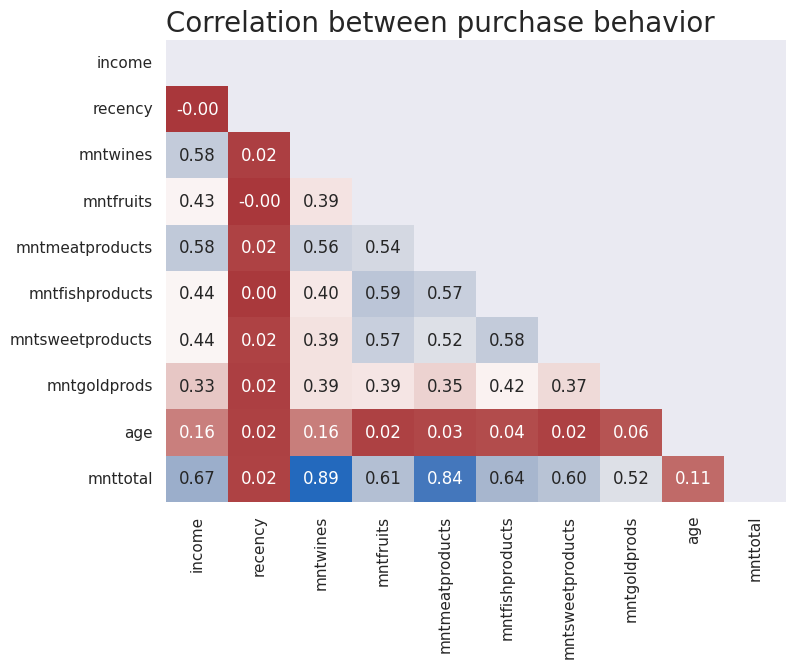

In [26]:
purchase_numbers = purchase.select_dtypes('number')
plt.figure(figsize=(8,6))
mask = np.triu(np.ones_like(purchase_numbers.corr(), dtype=bool))
sns.heatmap(purchase_numbers.corr(), annot=True, cmap='vlag_r', fmt='.2f', cbar=False, mask=mask)
plt.title('Correlation between purchase behavior', size=20, loc='left')
plt.show()

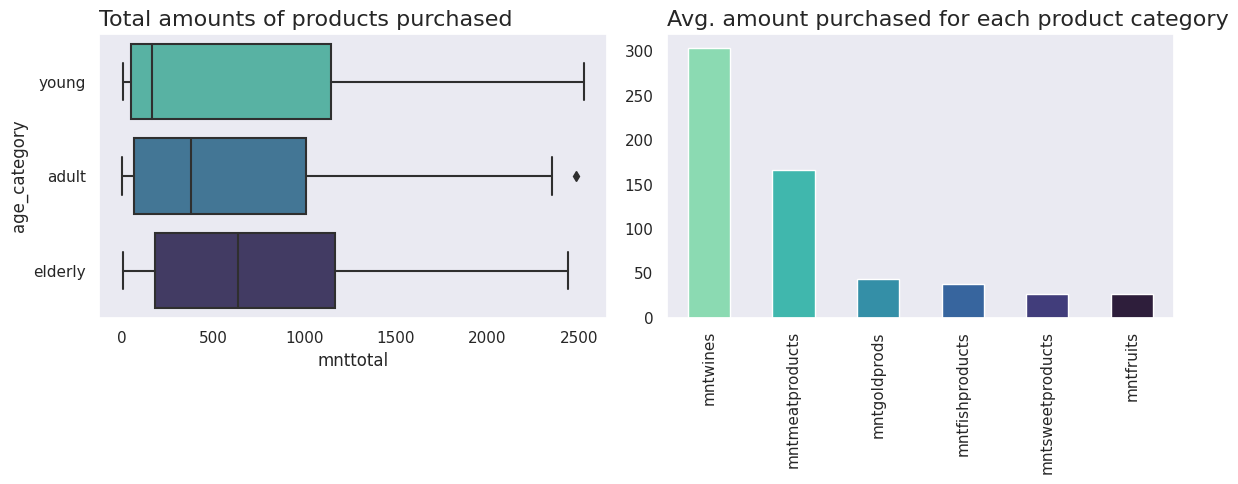

In [27]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

sns.boxplot(x='mnttotal', 
            y='age_category', 
            data=purchase, 
            palette='mako_r', 
            linewidth=1.5,
           ax=ax[0])
ax[0].set_title('Total amounts of products purchased', loc='left', size=16)

df_copy.loc[:,'mntwines':'mntgoldprods'].mean().sort_values(ascending=False)\
    .plot(kind='bar', 
          color=sns.color_palette('mako_r'),
         ax=ax[1])
ax[1].set_title('Avg. amount purchased for each product category', size=16, loc='left')

plt.tight_layout()
plt.show()

In [28]:
df_copy['mnttotal'] = df_copy.loc[:,'mntwines':'mntgoldprods'].sum(1)

**Let's see the distribution of total amount purchased**

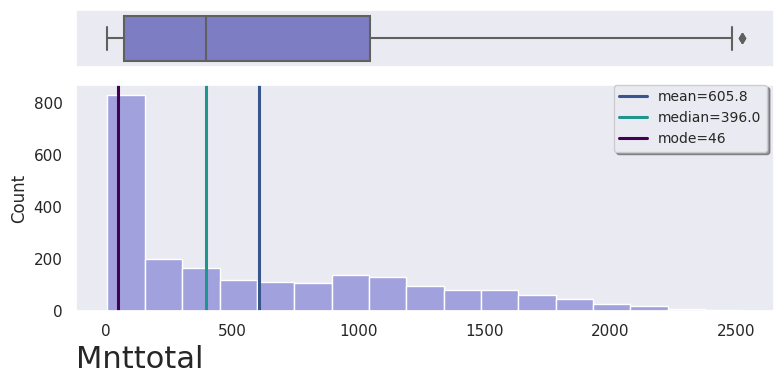

In [29]:
num_plot(purchase,'mnttotal')
plt.show()

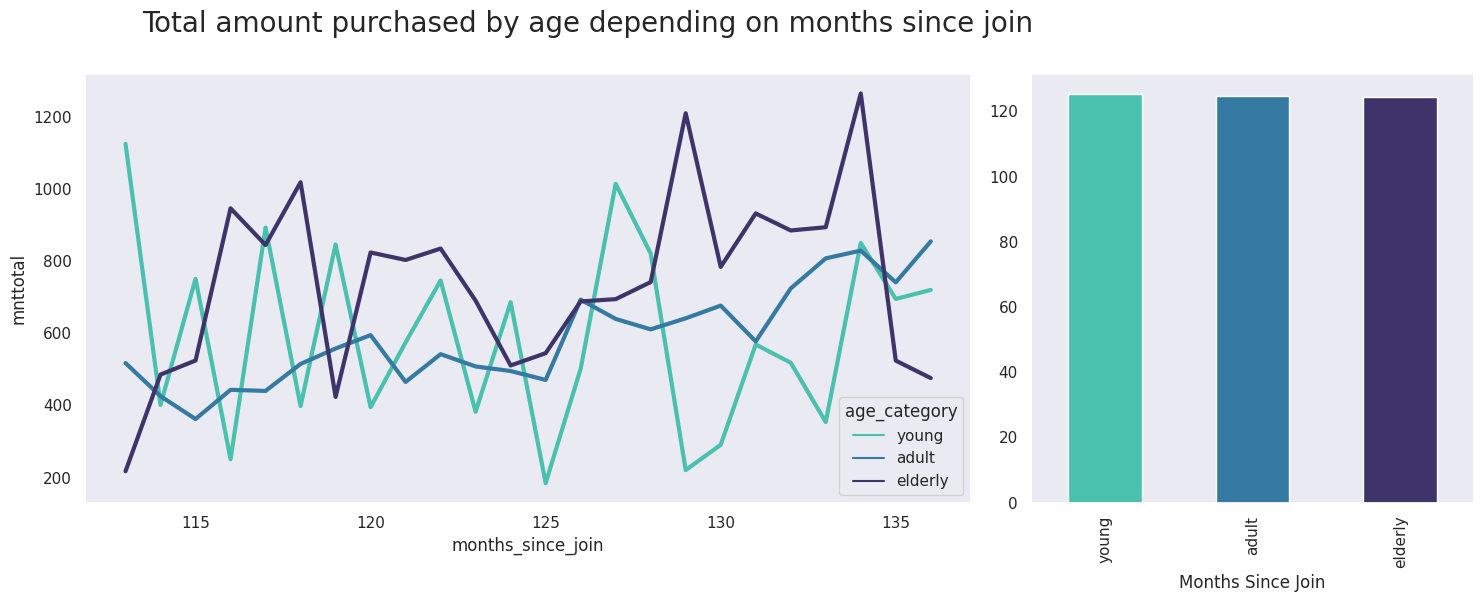

In [30]:
purchase['months_since_join'] = ((datetime.now() - purchase['dt_customer']) / pd.Timedelta(days=30)).astype(int)
group_by_months = purchase.groupby(['months_since_join','age_category'])['mnttotal'].mean().reset_index()

fig, ax = plt.subplots(1,2, figsize=(15,6), gridspec_kw={'width_ratios': [2, 1]})

sns.lineplot(x='months_since_join', 
             y='mnttotal', 
             data=group_by_months, 
             hue='age_category',
             ax=ax[0], 
             palette='mako_r',
            linewidth=3)

purchase.groupby('age_category')['months_since_join'].mean().plot(kind='bar', 
                                                                  color=sns.color_palette('mako_r',3),
                                                                  xlabel='Months Since Join',
                                                                 ax=ax[1])

plt.suptitle('Total amount purchased by age depending on months since join', 
             x=0.1, y=1.0, fontsize=20, ha="left")
plt.tight_layout()
plt.show()

**Is there a significant difference in spending behavior if we grouped by marital status?**

In [31]:
products = ['mntwines','mntfruits','mntmeatproducts',
            'mntfishproducts','mntsweetproducts','mntgoldprods','mnttotal']

purchase.groupby('partner')[products].mean().astype(int).style.background_gradient(cmap='vlag_r')

,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,mnttotal
partner,,,,,,,
No Partner,306,27,172,38,28,46,620
Partner,302,25,163,36,26,42,597


In [32]:
temp_df = pd.pivot_table(purchase, index='partner', columns='age_category', values='mnttotal', aggfunc='mean')
print('Avg. Total amount purchased:')
temp_df.fillna(0).astype(int).style.background_gradient(cmap='vlag_r')

Avg. Total amount purchased:


age_category,young,adult,elderly
partner,,,
No Partner,605,609,696
Partner,554,576,776


## 4.3 Looking for patterns in purchasing channels

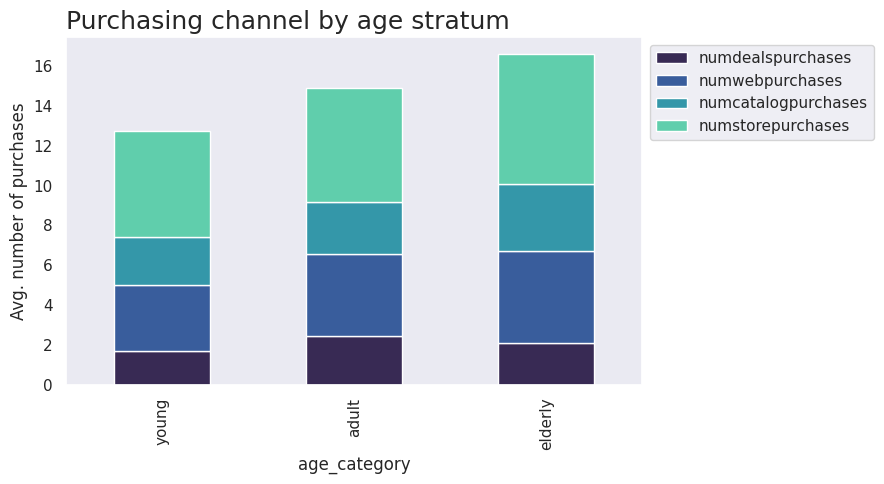

In [33]:
purchasing_channels = ['numdealspurchases','numwebpurchases','numcatalogpurchases','numstorepurchases']
fig, ax = plt.subplots(figsize=(9,5))
df_copy.groupby('age_category')[purchasing_channels].mean()\
                            .plot(kind='bar', ax=ax, stacked=True,
                            color=sns.set_palette('mako',4))

plt.title('Purchasing channel by age stratum', loc='left', size=18)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_ylabel('Avg. number of purchases')
plt.tight_layout()
plt.show()

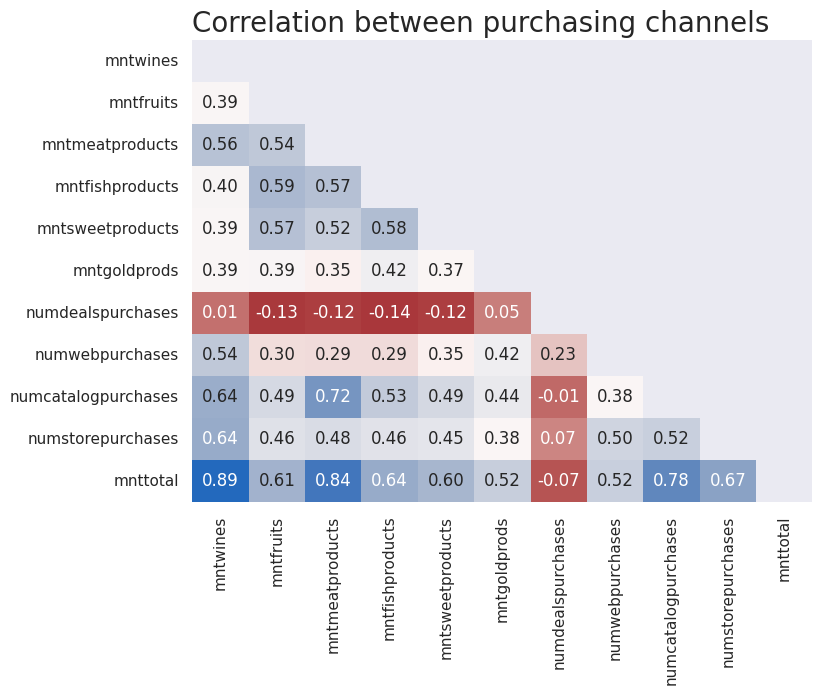

In [34]:
purchasing_channel = pd.concat([df_copy.loc[:,'mntwines':'numstorepurchases'], df_copy['mnttotal']], axis=1)

plt.figure(figsize=(8,6))
mask = np.triu(np.ones_like(purchasing_channel.corr(), dtype=bool))
sns.heatmap(purchasing_channel.corr(), annot=True, cmap='vlag_r', fmt='.2f', cbar=False, mask=mask)
plt.title('Correlation between purchasing channels', size=20, loc='left')
plt.show()

## 4.4 Analyze campaign acceptance

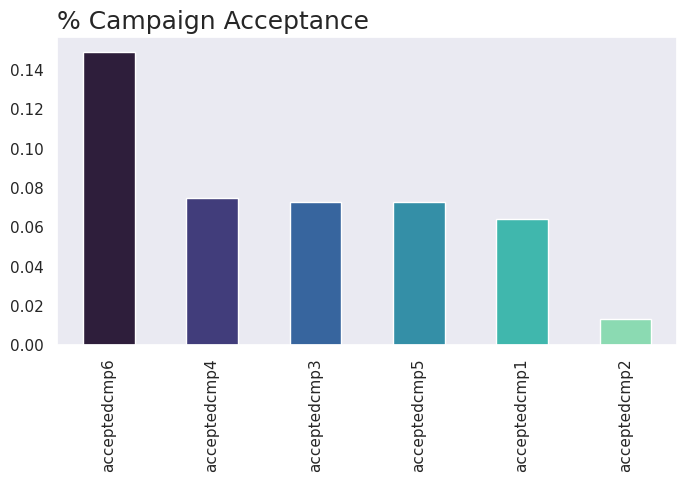

In [35]:
campaigns = df_copy.loc[:,'acceptedcmp3':'response'].drop('complain', axis=1)

# Rename response as acceptedcmp6 for more practicity
campaigns.rename(columns={'response':'acceptedcmp6'}, inplace=True)

# Plot the acceptance ratio for each campaign
fig, ax = plt.subplots(figsize=(8,4))
campaigns.mean().sort_values(ascending=False).plot(kind='bar', color=sns.color_palette('mako'), 
                                                  ax=ax)
ax.set_title('% Campaign Acceptance', size=18, loc='left')
plt.show()

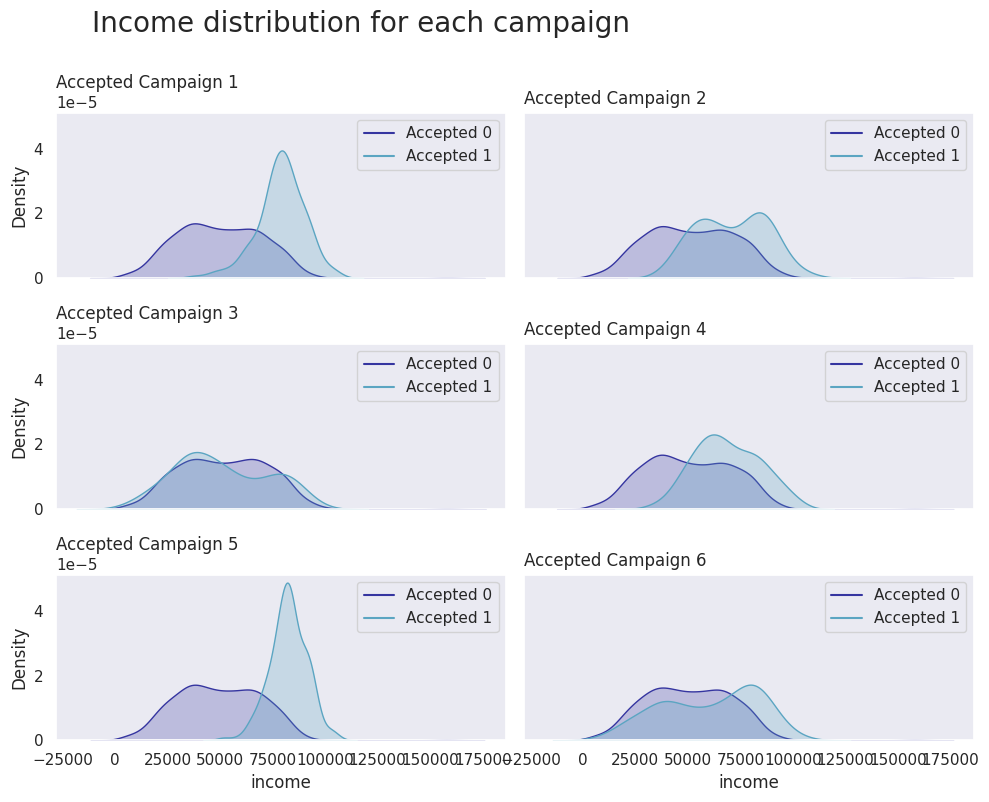

In [36]:
df_without_outliers.rename(columns={'response': 'acceptedcmp6'}, inplace=True)

fig, ax = plt.subplots(3, 2, figsize=(10, 8), sharex=True, sharey=True)
colors = ['#3535a0', '#5ba5c2']

for i, ax in enumerate(ax.flat):
    sns.kdeplot(data=df_without_outliers[df_without_outliers[f'acceptedcmp{i+1}'] == 0],
                x='income', shade=True, color=colors[0], label='Accepted 0', ax=ax)
    sns.kdeplot(data=df_without_outliers[df_without_outliers[f'acceptedcmp{i+1}'] == 1],
                x='income', shade=True, color=colors[1], label='Accepted 1', ax=ax)
    
    ax.set_title(f'Accepted Campaign {i + 1}', size=12, loc='left')
    custom_legend = [
        Line2D([0], [0], color=colors[0], lw=1.5, linestyle='-', label='Accepted 0'),
        Line2D([0], [0], color=colors[1], lw=1.5, linestyle='-', label='Accepted 1')
    ]
    ax.legend(handles=custom_legend)

plt.suptitle('Income distribution for each campaign',
                         x=0.1, y=1.0, fontsize=20, ha="left")
plt.tight_layout()
plt.show()

**How many people accepted more than one campaign?**

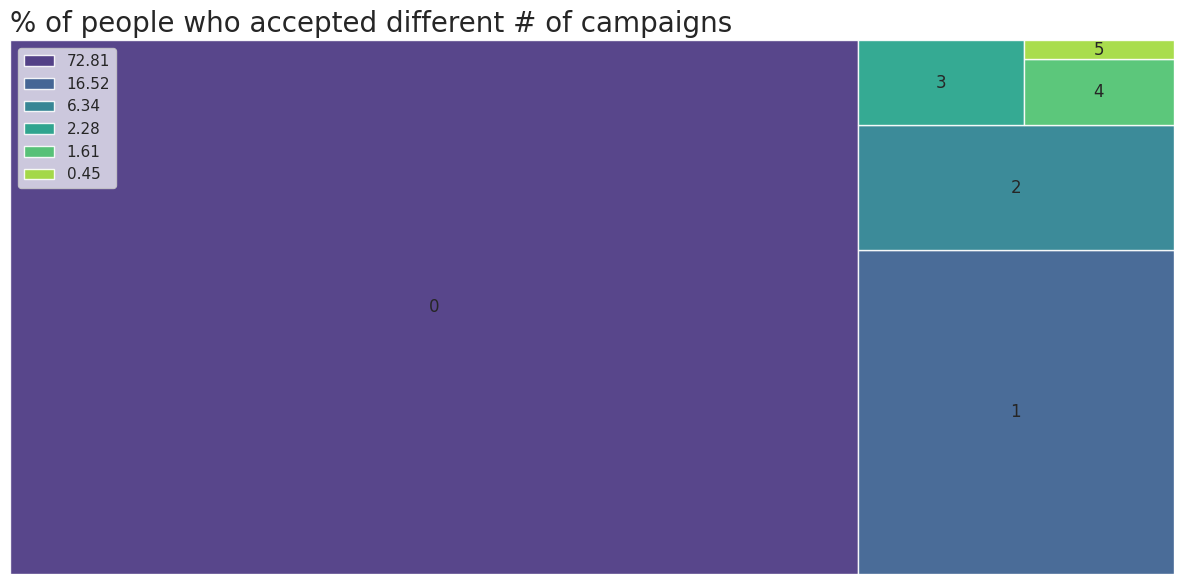

In [37]:
people_acceptance = campaigns.sum(1).value_counts(normalize=True).sort_values(ascending=False)

plt.figure(figsize=(12,6))
squarify.plot(sizes=people_acceptance, label=people_acceptance.index,
              color=sns.color_palette('viridis',len(people_acceptance)),
              alpha=.9)
plt.legend(np.round(people_acceptance*100,2))
plt.axis('off')
plt.title('% of people who accepted different # of campaigns', loc='left', size=20)
plt.tight_layout()
plt.show()

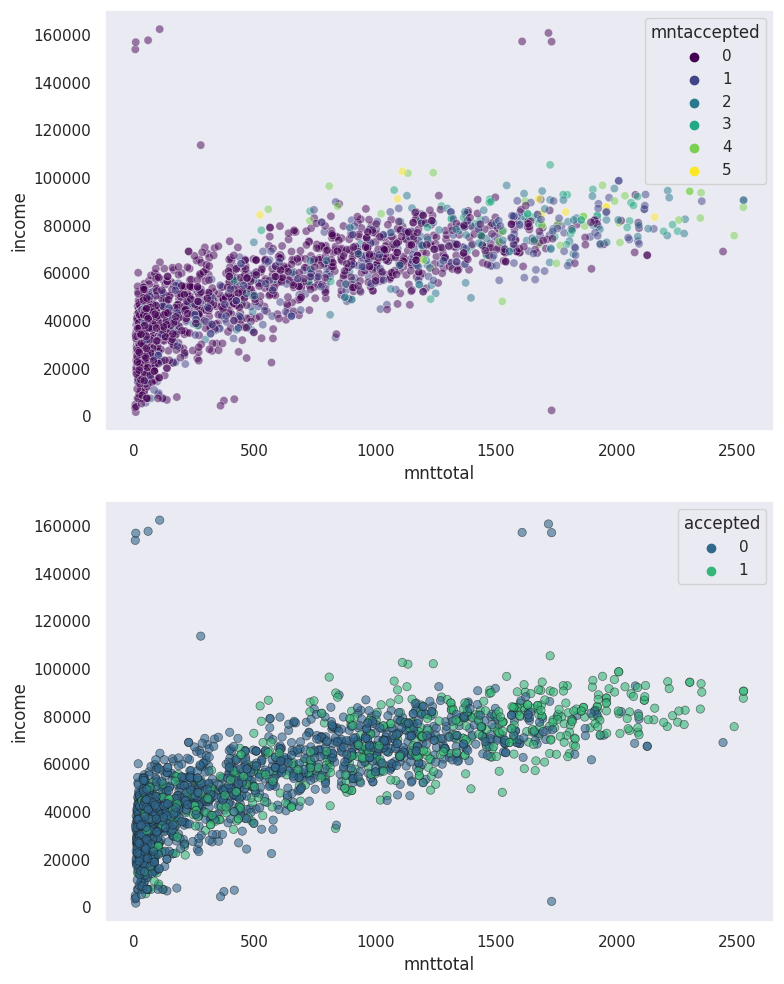

In [38]:
df_without_outliers = df_copy.loc[(df_copy.year_birth > 1940) & (df_copy.income < 200_000)]
df_without_outliers['mntaccepted'] = campaigns.sum(1)
df_without_outliers['accepted'] = df_without_outliers['mntaccepted'].apply(lambda x: 1 if x > 0 else x)

fig, ax = plt.subplots(2, figsize=(8,10))
sns.scatterplot(data=df_without_outliers,
                        x='mnttotal', y='income',
                        hue='mntaccepted',
                        palette='viridis',
                        alpha=.5,
                        ax=ax[0])


sns.scatterplot(data=df_without_outliers,
                        x='mnttotal', y='income',
                        hue='accepted',
                        palette='viridis',
                        alpha=.6,
                        edgecolor='k',
                        ax=ax[1])

plt.tight_layout()
plt.show()

**Is there a common demographic factor?**

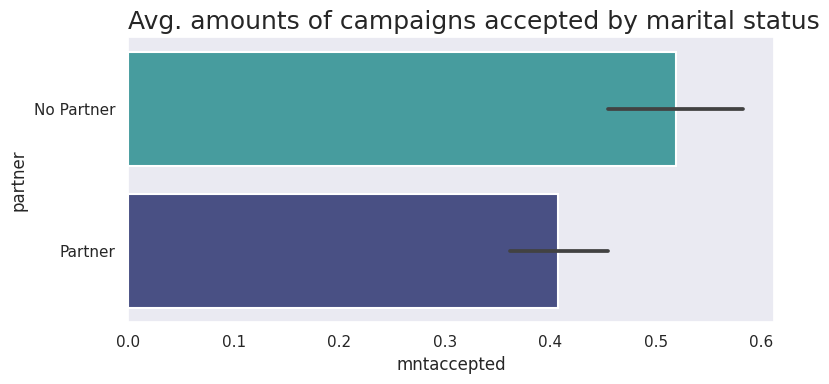

In [39]:
df_copy['mntaccepted'] = campaigns.sum(1)

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(x='mntaccepted', y='partner', data=df_copy, palette='mako_r', linewidth=1.5)
ax.set_title('Avg. amounts of campaigns accepted by marital status', size=18, 
             loc='left')
plt.tight_layout()
plt.show()

## 4.5 Complains

**How many customers have complained?**

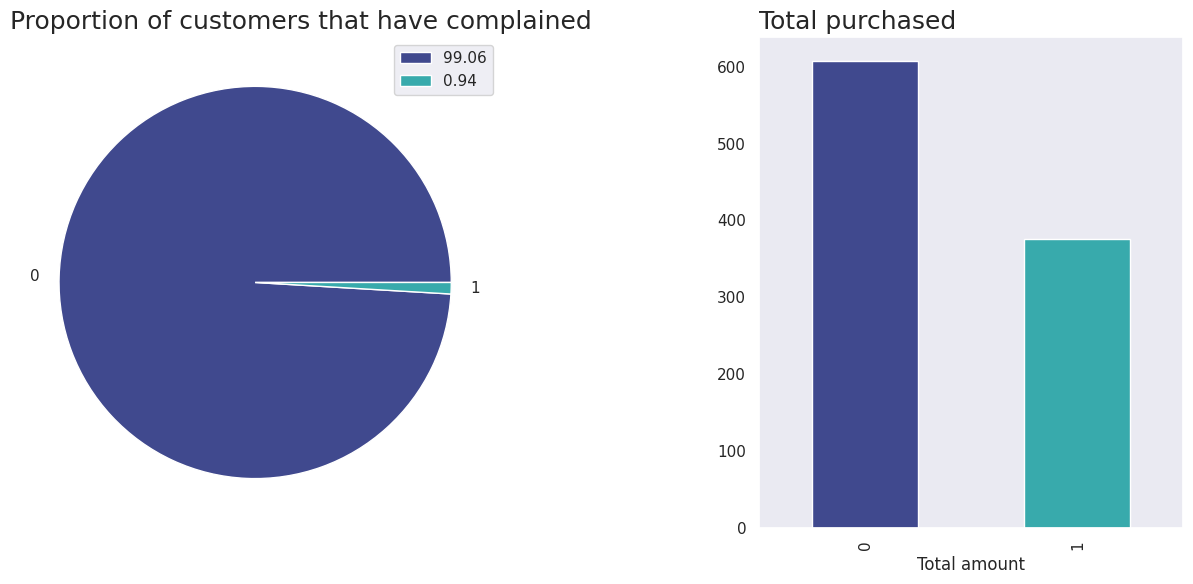

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), gridspec_kw={'width_ratios': [3, 1]})

df_copy.loc[:, 'complain'].value_counts().plot(kind='pie', ax=axes[0], colors=sns.color_palette('mako', 2))
axes[0].set_title('Proportion of customers that have complained', size=18, loc='left')
axes[0].legend(np.round(df_copy.loc[:, 'complain'].value_counts(normalize=True) * 100, 2))
axes[0].axis('off')

df_copy.groupby('complain')['mnttotal'].mean().plot(kind='bar', color=sns.color_palette('mako', 2), ax=axes[1])
axes[1].set_title('Total purchased', size=18, loc='left')
axes[1].set_xlabel('Total amount')

plt.tight_layout()
plt.show()

In [41]:
df.isnull().sum().sort_values(ascending=False)[:1]

Income    24
dtype: int64

In [42]:
def outliers_treatment(df):
    """Capping outliers"""
    df_num = df.select_dtypes(['number'])
    for i in df_num:
        low = df[i].quantile(.01)
        up = df[i].quantile(.99)
        df[i] = df[i].apply(lambda x: low if x < low else up if x > up else x)
    return df

In [43]:
# Create the new columns
def modify_columns(df):
    """Creating previous columns"""
    df.columns = df.columns.str.lower()
    df['dt_customer'] = pd.to_datetime(df.dt_customer, format='%d-%m-%Y')
    # Create new columns
    not_graduated = ['Basic','2n cycle']
    couple = ['Married','Together']
    df['graduated'] = df['education'].apply(lambda x: 'Not Graduated' if x in not_graduated else 'Graduated')
    df['partner'] = df['marital_status'].apply(lambda x: 'Partner' if x in couple else 'No Partner')
    df['mnttotal'] = df.loc[:,'mntwines':'mntgoldprods'].sum(1)
    df['mntaccepted'] = pd.concat([df.loc[:,'acceptedcmp3':'acceptedcmp2'],df.loc[:,'response']], axis=1).sum(1)
    df['accepted'] = df['mntaccepted'].apply(lambda x: 1 if x > 0 else 0)
    df['age'] = max(pd.to_datetime(df['dt_customer']).dt.year) - df['year_birth']
    df['age_category'] = age_clusters
    return df

# Apply FunctionTransformer for the functions
mod_columns = FunctionTransformer(modify_columns)
log_transformer = FunctionTransformer(lambda x: np.log(x))

# Missing values
knn = KNNImputer(n_neighbors=3)

# Outliers treatment
capping_out = FunctionTransformer(outliers_treatment)

# Data Scaling and Formatting
sc = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')

# Create the column transformer
knn_sc_log = make_pipeline(log_transformer, sc, knn)
sc_log = make_pipeline(log_transformer, sc)

ct = make_column_transformer(
                             (knn_sc_log,['income']),
                             (sc_log,['mnttotal']),
                             (ohe,['partner','graduated']),
                              remainder='drop'
                              )
                              
# Create the pipeline
pipe = make_pipeline(
                     mod_columns,
                     capping_out,
                     ct
                     )
pipe

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function modify_columns at 0x7f33be1b0670>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function outliers_treatment at 0x7f33be1b0af0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function <lam...8b0>)),
                                                                  ('standardscaler',
                                                                   StandardScaler()),
                                                                  ('knnimputer',
                                                                   KNNImputer(n_neighbors=3))]),
                                                  ['income']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7f33be1b08b0>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['mnttotal']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['partner', 'graduated'])]))])

**Apply the pipeline to the original dataset**

In [44]:
df_copy_1 = df.copy()

df_prep = pipe.fit_transform(df_copy_1)

**Let's take a look of the first row!**

In [45]:
df_prep[:1]

array([[0.4455789 , 1.20390221, 1.        , 0.        , 1.        ,
        0.        ]])

**Get the columns names after applying the pipeline for further analysis**

In [46]:
columns = ['income','mnttotal']
ohe_columns = pipe.named_steps['columntransformer'].named_transformers_['onehotencoder'].get_feature_names_out().tolist()
column_names = columns + ohe_columns

**Check if there's no missing values:**

In [47]:
np.isnan(df_prep).sum()

0

# Modeling

## 6.1 K-Means

**Determine the optimal number of clusters using the silhouette diagrams and elbow method**

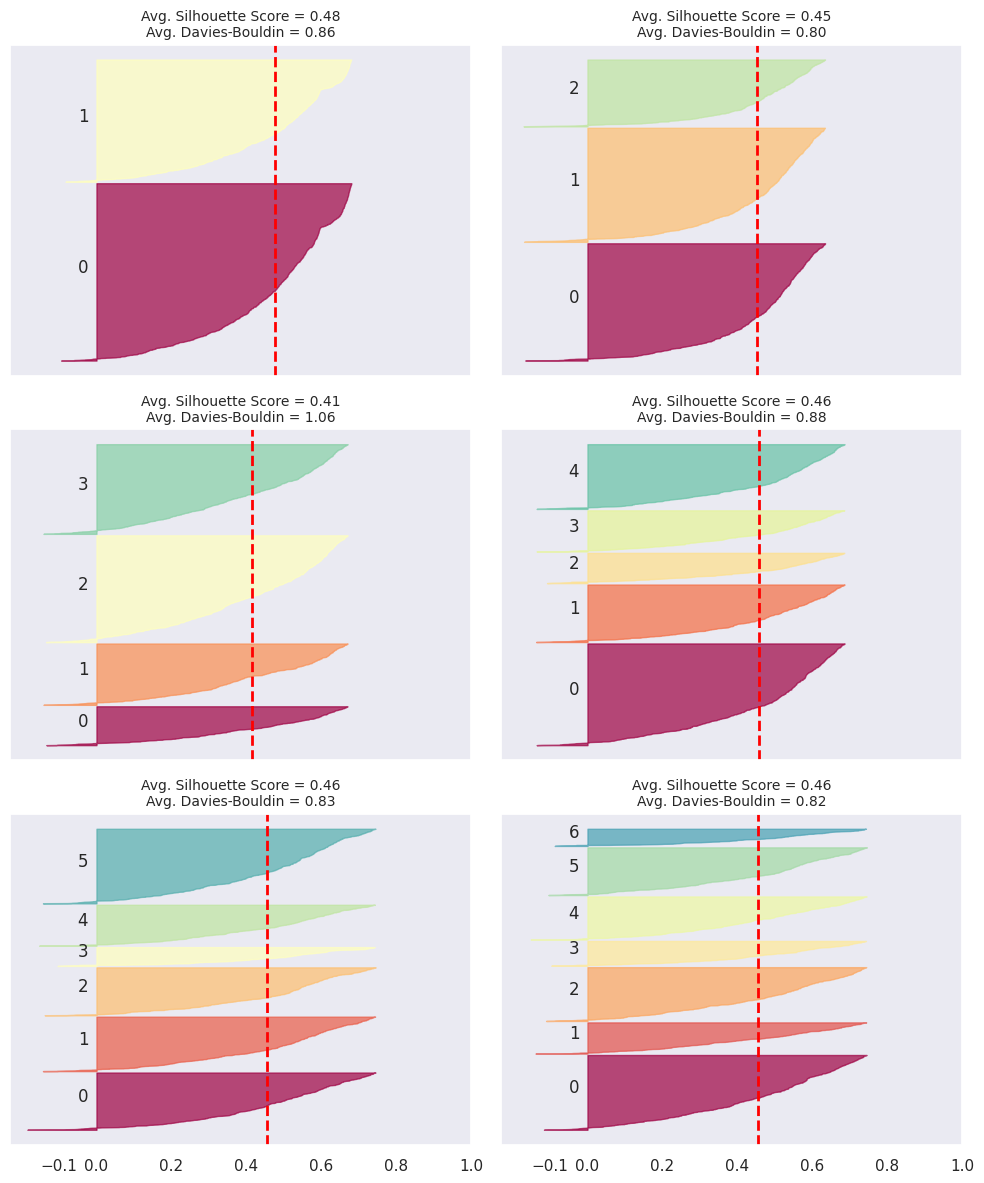

In [48]:
inertias = []
silhouette_scores = []
davies = []
k_values = range(2,8)

fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex=True)

for i, ax in enumerate(axes.flatten()):
    k = k_values[i]
    # Fit the model with k clusters
    kmeans = KMeans(n_clusters=k, n_init=50, random_state=0, algorithm='lloyd')
    kmeans.fit(df_prep)
    # Compute inertia and silhouette scores
    silhouette_values = silhouette_samples(df_prep, kmeans.labels_)
    silhouette_values.sort()
    silhouette_avg = silhouette_score(df_prep, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    inertias.append(kmeans.inertia_)
    davies.append(davies_bouldin_score(df_prep, kmeans.labels_))

    # Add a silhouette plot for each cluster
    y_lower = 10
    ax.set_title(f"Avg. Silhouette Score = {silhouette_avg:.2f}\nAvg. Davies-Bouldin = {davies_bouldin_score(df_prep, kmeans.labels_):.2f}", 
                 size=10)
    for j in range(k):
        ith_cluster = silhouette_values[kmeans.labels_ == j]
        size_cluster_j = ith_cluster.shape[0]
        y_upper = y_lower + size_cluster_j

        color = plt.cm.get_cmap("Spectral")(float(j) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster,
                         facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))

        # Compute the new y_lower for the next plot
        y_lower = y_upper + 10

    ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=2)

    ax.set_yticks([])
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.tight_layout()
plt.show()

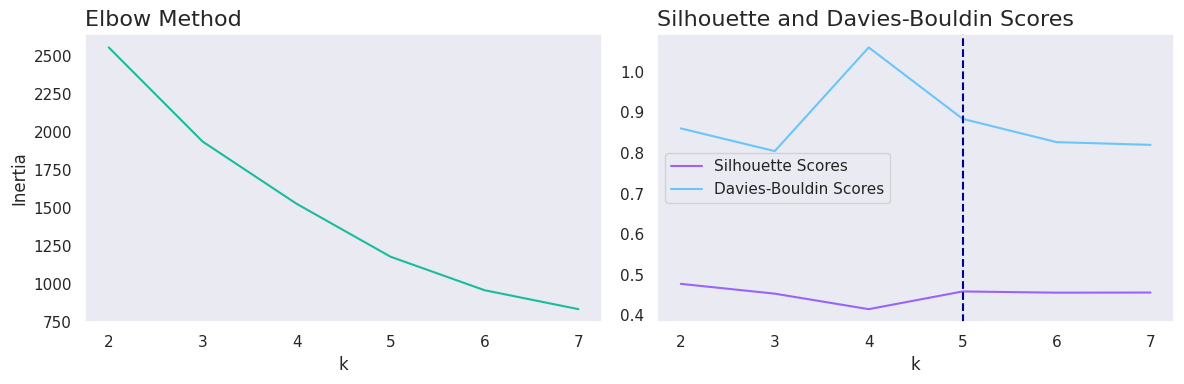

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plot the Elbow Method
sns.lineplot(x=range(2, 8), y=inertias, color='#1ABC9C', ax=ax[0])
ax[0].set_title('Elbow Method', size=16, loc='left')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Inertia')

# Plot Silhouette and Davies-Bouldin Scores
sns.lineplot(x=range(2, 8), y=silhouette_scores, color='#762CFF', label='Silhouette Scores', alpha=0.7, ax=ax[1])
sns.lineplot(x=range(2, 8), y=davies, color='#34B6FF', label='Davies-Bouldin Scores', alpha=0.7, ax=ax[1])
ax[1].set_title('Silhouette and Davies-Bouldin Scores', size=16, loc='left')
ax[1].set_xlabel('k')
ax[1].legend()
ax[1].axvline(5, linewidth=1.5, color='darkblue', linestyle='--')

plt.tight_layout()
plt.show()

In [50]:
kmeans = KMeans(n_clusters=5, n_init=50, random_state=0)
kmeans_labels = kmeans.fit_predict(df_prep)
print(f"Silhouette Score: {silhouette_score(df_prep, kmeans_labels)}")
print('Davies-Bouldin Score: ',davies_bouldin_score(df_prep, kmeans_labels))

Silhouette Score: 0.4586128513601604
Davies-Bouldin Score:  0.8842415011596627


## 6.2 DBSCAN

In [51]:
dbscan = DBSCAN(eps=0.3, min_samples=50, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(df_prep)

print(f"Silhouette Score: {silhouette_score(df_prep, dbscan_labels)}")
print('Davies-Bouldin Score: ',davies_bouldin_score(df_prep, dbscan_labels))

Silhouette Score: 0.29134507461043874
Davies-Bouldin Score:  1.086719640914308


## 6.3 Hierarchical Clustering

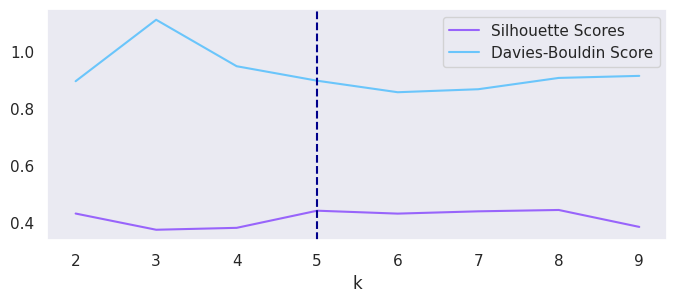

In [52]:
agg_cluster = AgglomerativeClustering(n_clusters=None, distance_threshold=2.0)
agg_cluster.fit(df_prep)

sil_score = []
davies = []
for k in range(2,10):
    if k < len(agg_cluster.children_):
        agg_labels = AgglomerativeClustering(n_clusters=k).fit_predict(df_prep)
        sil_score.append(silhouette_score(df_prep,agg_labels))
        davies.append(davies_bouldin_score(df_prep, agg_labels))
    else:
        agg_labels = agg_cluster.labels_
        print('K: ',k)
        print('Silhouette score: ',silhouette_score(df_prep,agg_labels))
        print('Davies-Bouldin Score: ',davies_bouldin_score(df_prep, agg_labels))

# Let's plot the scores for each cut-off number
plt.figure(figsize=(8,3))
sns.lineplot(x=range(2, 10), y=sil_score, color='#762CFF', label='Silhouette Scores', alpha=.7)
sns.lineplot(x=range(2, 10), y=davies, color='#34B6FF', label='Davies-Bouldin Score', alpha=.7)
plt.axvline(5, linewidth=1.5, color='darkblue', linestyle='--')
plt.xlabel('k')

plt.show()

In [53]:
agg_cluster = AgglomerativeClustering(n_clusters=5)
agg_labels = agg_cluster.fit_predict(df_prep)
print('Silhouette score: ',silhouette_score(df_prep,agg_labels))
print('Davies-Bouldin Score: ',davies_bouldin_score(df_prep, agg_labels))

Silhouette score:  0.43991226757359647
Davies-Bouldin Score:  0.8970793288643437


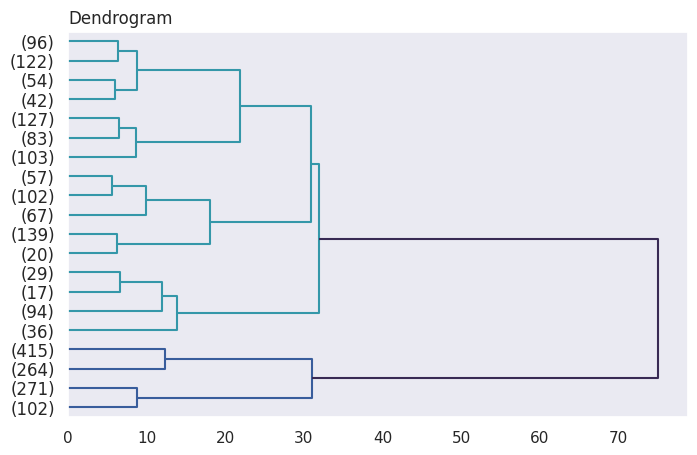

In [54]:
linkage_matrix = linkage(df_prep, method='ward')

plt.figure(figsize=(8,5))
dendrogram(linkage_matrix, orientation='right', truncate_mode='lastp', p=20)
plt.title("Dendrogram", loc='left')
plt.show()

<a id="6"></a>
# <p style="background-color:#616EDD;font-family:sans-serif;color:#FFFFFF;font-size:120%;text-align:left;border-radius:12px 12px;">7. Explore the clusters results</p>
The KMeans algorithm has demonstrated superior performance in terms of silhouette and Davies-Bouldin scores,
suggesting its effectiveness for our clustering task.

**Concatenate cluster classes with the original dataset**

In [55]:
df_clustered = pd.concat([df_copy_1.reset_index().drop('index', axis=1), 
                          pd.Series(kmeans_labels, name='KMeans', dtype='object')],
                          axis=1)

# Create the previous columns
modify_columns(df_clustered)

df_clustered.head(3)

,id,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,acceptedcmp3,acceptedcmp4,acceptedcmp5,acceptedcmp1,acceptedcmp2,complain,z_costcontact,z_revenue,response,graduated,partner,mnttotal,mntaccepted,accepted,age,age_category,kmeans
0,5524.0,1957.0,Graduation,Single,58138.0,0,0,2012-09-04,58.0,635.0,88.0,546.0,172.0,88.0,88.0,3.0,8.0,10.0,4.0,7.0,0,0,0,0,0,0.0,3,11,1,Graduated,No Partner,1617.0,1,1,57.0,adult,1
1,2174.0,1954.0,Graduation,Single,46344.0,1,1,2014-03-08,38.0,11.0,1.0,6.0,2.0,1.0,6.0,2.0,1.0,1.0,2.0,5.0,0,0,0,0,0,0.0,3,11,0,Graduated,No Partner,27.0,0,0,60.0,adult,3
2,4141.0,1965.0,Graduation,Together,71613.0,0,0,2013-08-21,26.0,426.0,49.0,127.0,111.0,21.0,42.0,1.0,8.0,2.0,10.0,4.0,0,0,0,0,0,0.0,3,11,0,Graduated,Partner,776.0,0,0,49.0,adult,0


**Let's create a custom color palette to indentify clusters more easily**

In [56]:
custom_colors = {
    0: '#471164FF',
    1: '#3B528BFF',
    2: '#35B779FF',
    3: '#AADC32FF',
    4: '#FDE725FF'
}

colors = [custom_colors[cluster] for cluster in sorted(df_clustered['kmeans'].unique())]
custom_palette_kmeans = sns.set_palette(colors)

### **How many customers do we have in each cluster?**

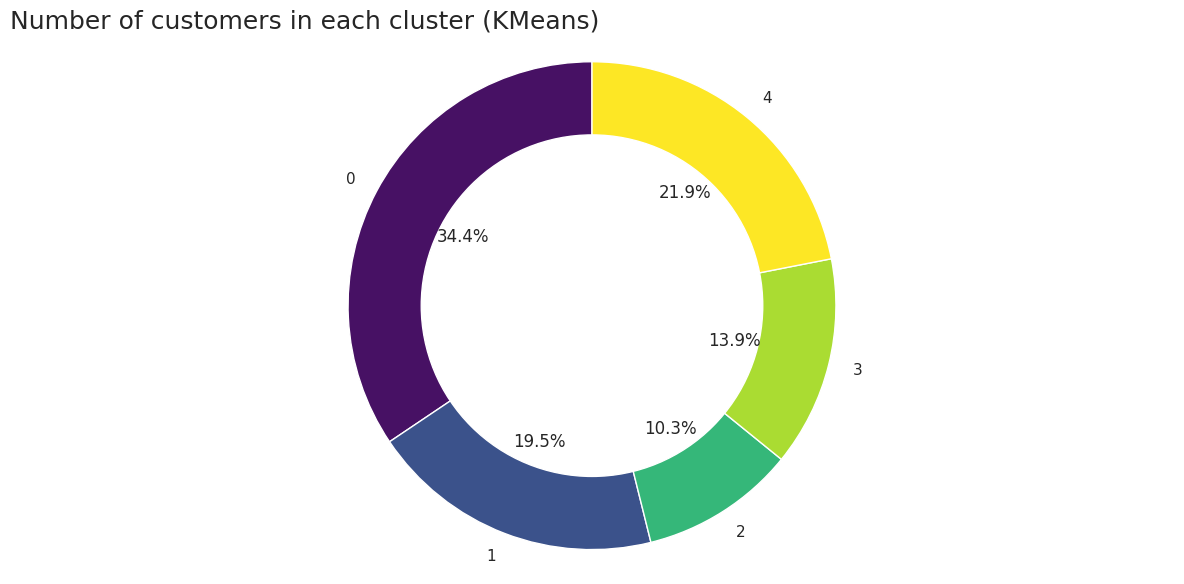

In [57]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title('Number of customers in each cluster (KMeans)', loc='left', size=18)
kmeans_counts = df_clustered['kmeans'].value_counts().sort_index()
pie = ax.pie(kmeans_counts, labels=kmeans_counts.index, autopct='%1.1f%%', startangle=90,
             wedgeprops=dict(width=0.4, edgecolor='w'), colors=colors)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.tight_layout()
plt.show()

### **Income vs. Total amount purchased**

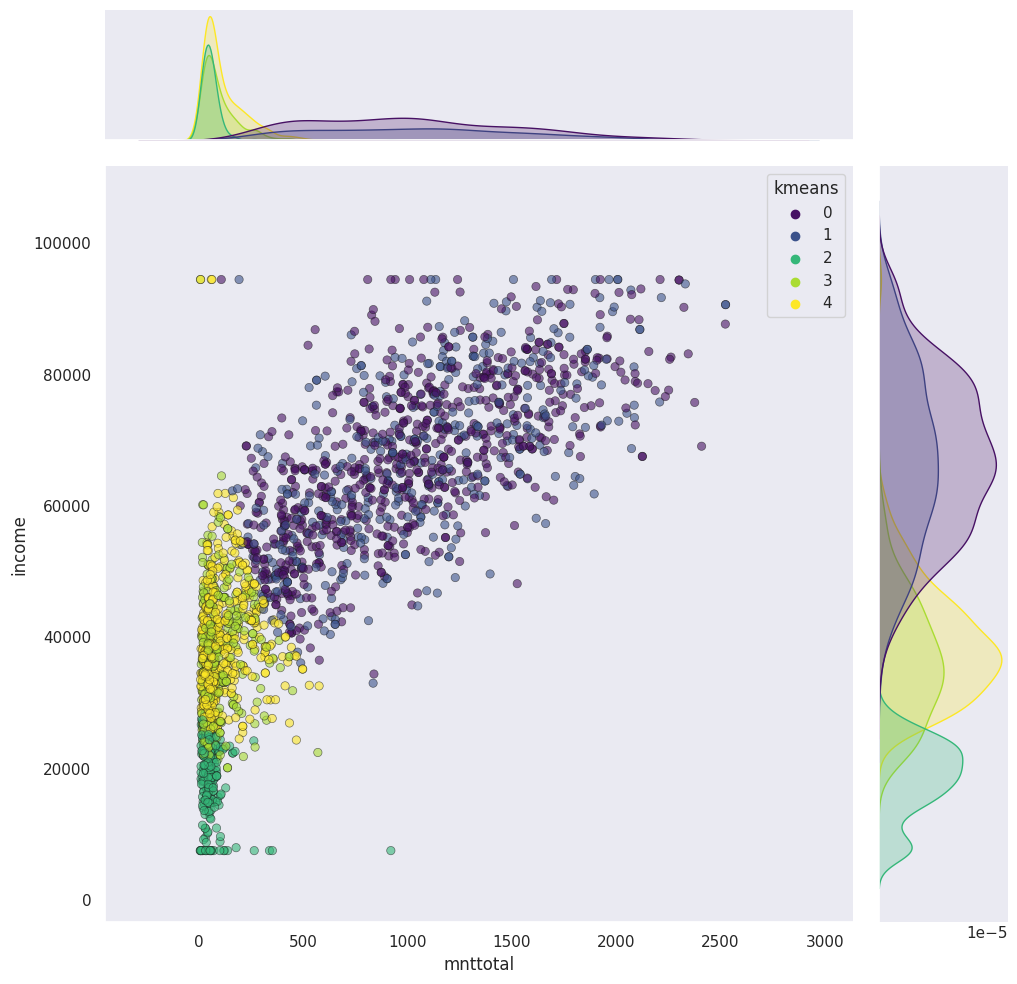

In [58]:
# KMeans
sns.jointplot(data=df_clustered,
                        x='mnttotal', y='income',
                        hue='kmeans',
                        palette=sns.color_palette(custom_palette_kmeans),
                        alpha=.6,
                        height=10,
                        edgecolor='k')
plt.show()

## 7.2 Demographic Charateristics

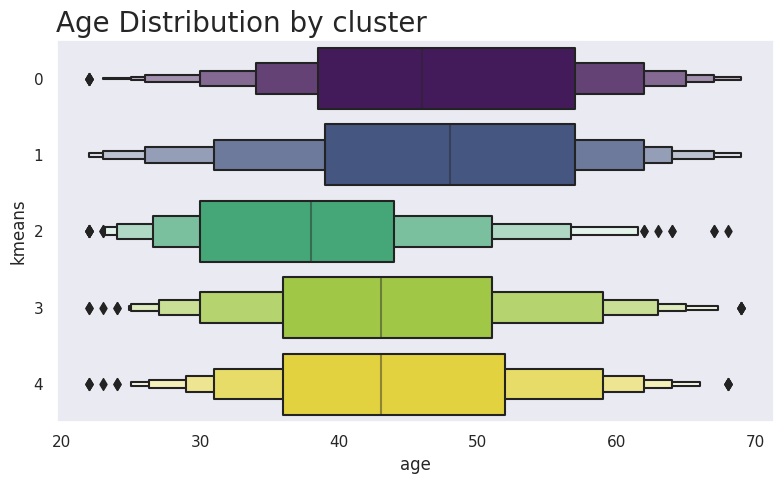

In [59]:
fig, ax = plt.subplots(figsize=(8,5))

# KMeans
sns.boxenplot(x='age', y='kmeans', data=df_clustered, linewidth=1.5, orient='h')
ax.set_title('Age Distribution by cluster', loc='left', size=20)

plt.tight_layout()
plt.show()

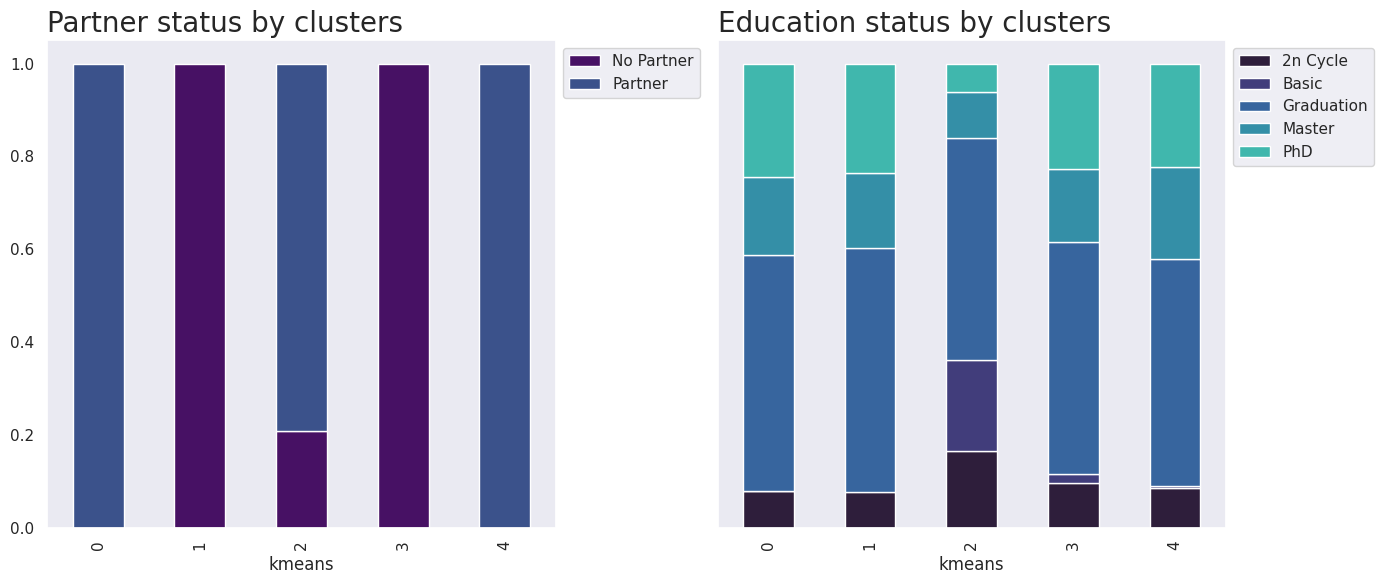

In [60]:
group_by_partner = df_clustered.groupby('kmeans')['partner'].value_counts(normalize=True).unstack()
group_by_graduated = df_clustered.groupby('kmeans')['education'].value_counts(normalize=True).unstack()

fig, ax = plt.subplots(1,2, figsize=(14,6), sharey=True)

group_by_partner.plot(kind='bar', 
                      stacked=True,
                     ax=ax[0])

ax[0].set_title('Partner status by clusters', size=20, loc='left')
ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

group_by_graduated.plot(kind='bar', 
                      stacked=True,
                     ax=ax[1],
                       color=sns.color_palette('mako'))

ax[1].set_title('Education status by clusters', size=20, loc='left')
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

## 7.3 Spending behavior and receptivity to campaigns

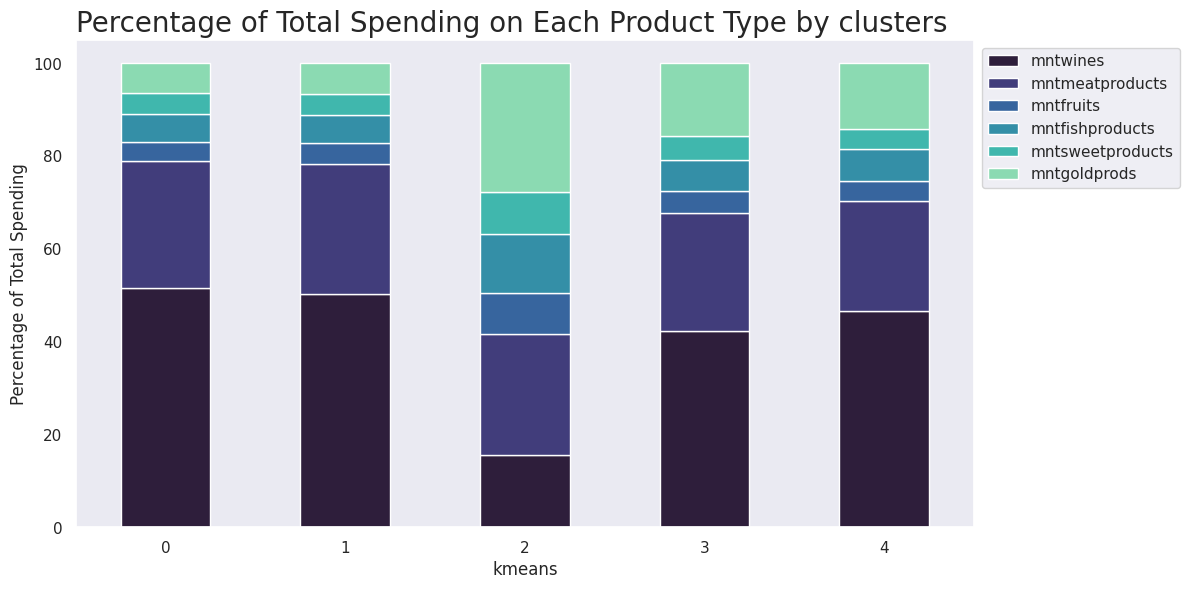

In [61]:
prod_columns = ['mntwines','mntmeatproducts','mntfruits','mntfishproducts',
                'mntsweetproducts','mntgoldprods']

df_grouped = df_clustered.groupby('kmeans')[prod_columns].mean()

df_percentage = df_grouped.divide(df_grouped.sum(axis=1), axis=0) * 100

ax = df_percentage.plot(kind='bar', ylabel='Percentage of Total Spending', 
                   figsize=(10, 6),
                   stacked=True,
                   color=sns.color_palette('mako',6))

ax.set_title('Percentage of Total Spending on Each Product Type by clusters', size=20, loc='left')

plt.tight_layout()
plt.xticks(rotation=0)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

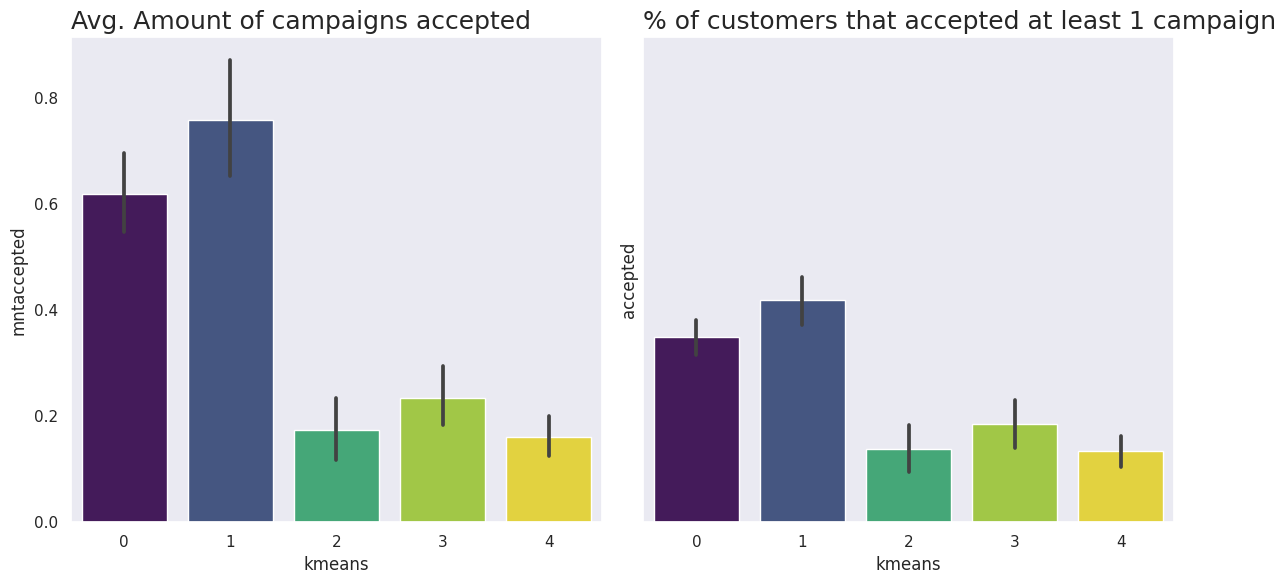

In [62]:
avg_mntaccepted = df_clustered.groupby('kmeans')['mntaccepted'].mean()
percentage_accepted = df_clustered.groupby('kmeans')['accepted'].mean()

fig , ax = plt.subplots(1, 2, figsize=(12,6), sharey=True)

sns.barplot(data=df_clustered, x='kmeans', y='mntaccepted',
                     ax=ax[0])
ax[0].set_title('Avg. Amount of campaigns accepted', size=18, loc='left')

sns.barplot(data=df_clustered, x='kmeans', y='accepted',
                     ax=ax[1])
ax[1].set_title('% of customers that accepted at least 1 campaign', size=18, loc='left')

plt.tight_layout()
plt.show()

## 7.4 Plot the clusters in 3D

In [63]:
def plot_3d(elev, azim):
    fig = plt.figure(figsize=(18, 12))
    ax = fig.add_subplot(111, projection='3d')

    for clase, color in custom_colors.items():
        df_3d = df_clustered[df_clustered.income < 120_000]
        subset = df_3d[df_3d.kmeans == clase]
        ax.scatter(subset['mnttotal'], subset['income'], subset['mntaccepted'], 
                   c=color, label=clase, alpha=.7)

    ax.set_zlim(0, 5)
    ax.view_init(elev=elev, azim=azim)

    ax.set_facecolor('#EAEBF2')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlabel('MntTotal', fontsize=14)
    ax.set_ylabel('Income', fontsize=14)
    ax.set_zlabel('MntAccepted', fontsize=14)
    ax.set_title('Clusters in 3D', fontsize=22)

    legend = ax.legend()
    for text in legend.get_texts():
        text.set_fontsize(12)

    plt.show()

interact(plot_3d, elev=(-90, 90), azim=(0, 360))

interactive(children=(IntSlider(value=0, description='elev', max=90, min=-90), IntSlider(value=180, descriptio…

<function __main__.plot_3d(elev, azim)>